<a href="https://colab.research.google.com/github/Zain-Haider-1824/Fully-Convolutional-Neural-Networks-for-Image-Segmentation-on-Oxford-IIIT-Pets-dataset/blob/main/Fully_Convolutional_Neural_Networks_for_Image_Segmentation_on_Oxford_IIIT_Pets_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns

from tensorflow import keras
import tensorflow as tf
import tensorflow_datasets as tfds
import cv2
import PIL
from IPython.display import clear_output

#Download the Dataset

In [2]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)
dataset

{'test': <PrefetchDataset shapes: {file_name: (), image: (None, None, 3), label: (), segmentation_mask: (None, None, 1), species: ()}, types: {file_name: tf.string, image: tf.uint8, label: tf.int64, segmentation_mask: tf.uint8, species: tf.int64}>,
 'train': <PrefetchDataset shapes: {file_name: (), image: (None, None, 3), label: (), segmentation_mask: (None, None, 1), species: ()}, types: {file_name: tf.string, image: tf.uint8, label: tf.int64, segmentation_mask: tf.uint8, species: tf.int64}>}

#Load and Preprocess the Dataset

In [3]:
def normalize(input_image, input_mask):
  img = tf.cast(input_image, dtype=tf.float32) / 255.0
  input_mask -= 1
  return img, input_mask

In [4]:
@tf.function
def load_train_ds(dataset):
  img = tf.image.resize(dataset['image'], size=(width, height))
  mask = tf.image.resize(dataset['segmentation_mask'], size=(width, height))

  if tf.random.uniform(()) > 0.5:
    img = tf.image.flip_left_right(img)
    mask = tf.image.flip_left_right(mask)
  
  img, mask = normalize(img, mask)
  return img, mask

In [5]:
@tf.function 
def load_test_ds(dataset):
  img = tf.image.resize(dataset['image'], size=(width, height))
  mask = tf.image.resize(dataset['segmentation_mask'], size=(width, height))
  
  img, mask = normalize(img, mask)
  return img, mask

In [6]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

width, height = 224, 224

In [7]:
train = dataset['train'].map(load_train_ds, num_parallel_calls=tf.data.AUTOTUNE)
test = dataset['test'].map(load_test_ds)

In [8]:
train, test

(<ParallelMapDataset shapes: ((224, 224, 3), (224, 224, 1)), types: (tf.float32, tf.float32)>,
 <MapDataset shapes: ((224, 224, 3), (224, 224, 1)), types: (tf.float32, tf.float32)>)

In [9]:
train_ds = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test.batch(BATCH_SIZE)

train_ds, test_ds

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None, 224, 224, 1)), types: (tf.float32, tf.float32)>,
 <BatchDataset shapes: ((None, 224, 224, 3), (None, 224, 224, 1)), types: (tf.float32, tf.float32)>)

#Visualize Image

In [10]:
def display_images(display_list):
  plt.figure(figsize = (15, 15))
  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  
  plt.show()

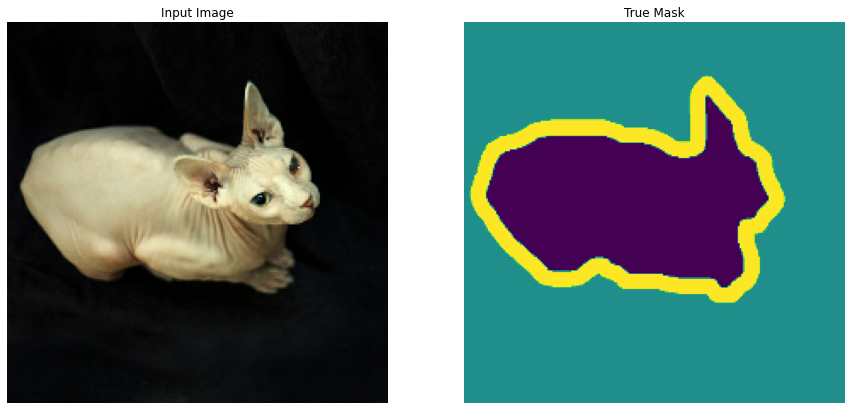

In [12]:
for img, mask in train.take(0):
  sample_image, sample_mask = img, mask
  display_list = sample_image, sample_mask

display_images(display_list)

#Define Model

#####VGG-16 Encoder

In [13]:
base_model = keras.applications.vgg16.VGG16(include_top=False, input_shape=(width, height, 3))

layer_names = [
               'block1_pool',
               'block2_pool',
               'block3_pool',
               'block4_pool',
               'block5_pool',
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]
base_model.trainable = False

VGG_16 = tf.keras.models.Model(base_model.input, base_model_outputs)

In [14]:
VGG_16.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

#####Fully-Convolutional-Network-8 Decoder

In [15]:
def fcn8_decoder(convs, n_classes):
  f1, f2, f3, f4, p5 = convs

  n = 4096
  c6 = tf.keras.layers.Conv2D( n , ( 7 , 7 ) , activation='relu' , padding='same', name="conv6")(p5)
  c7 = tf.keras.layers.Conv2D( n , ( 1 , 1 ) , activation='relu' , padding='same', name="conv7")(c6)

  f5 = c7

   # upsample the output of the encoder then crop extra pixels that were introduced
  o = tf.keras.layers.Conv2DTranspose(n_classes , kernel_size=(4,4) ,  strides=(2,2) , use_bias=False )(f5)
  o = tf.keras.layers.Cropping2D(cropping=(1,1))(o)

  # load the pool 4 prediction and do a 1x1 convolution to reshape it to the same shape of `o` above
  o2 = f4
  o2 = ( tf.keras.layers.Conv2D(n_classes , ( 1 , 1 ) , activation='relu' , padding='same'))(o2)

  # add the results of the upsampling and pool 4 prediction
  o = tf.keras.layers.Add()([o, o2])

  # upsample the resulting tensor of the operation you just did
  o = (tf.keras.layers.Conv2DTranspose( n_classes , kernel_size=(4,4) ,  strides=(2,2) , use_bias=False ))(o)
  o = tf.keras.layers.Cropping2D(cropping=(1, 1))(o)

  # load the pool 3 prediction and do a 1x1 convolution to reshape it to the same shape of `o` above
  o2 = f3
  o2 = ( tf.keras.layers.Conv2D(n_classes , ( 1 , 1 ) , activation='relu' , padding='same'))(o2)

  # add the results of the upsampling and pool 3 prediction
  o = tf.keras.layers.Add()([o, o2])
  
  # upsample up to the size of the original image
  o = tf.keras.layers.Conv2DTranspose(n_classes , kernel_size=(8,8) ,  strides=(8,8) , use_bias=False )(o)

  # append a softmax to get the class probabilities
  o = tf.keras.layers.Activation('softmax')(o)
  return o

#####Final Model

In [16]:
def segmentation_model():
  
  inputs = keras.layers.Input(shape = (width, height, 3)) 
  convs = VGG_16(inputs)
  outputs = fcn8_decoder(convs, 3)
  model = tf.keras.Model(inputs=inputs, outputs=outputs)
  
  return model

#####Compile Model

In [17]:
# opt = keras.optimizers.SGD(momentum=0.9)
opt = keras.optimizers.Adam()

model = segmentation_model()
model.compile(optimizer = opt,
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy'])

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

#####Creating Mask for predicted image & Visualization utilities

In [18]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [19]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display_images([image[0], mask[0], create_mask(pred_mask)])
  else:
    display_images([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

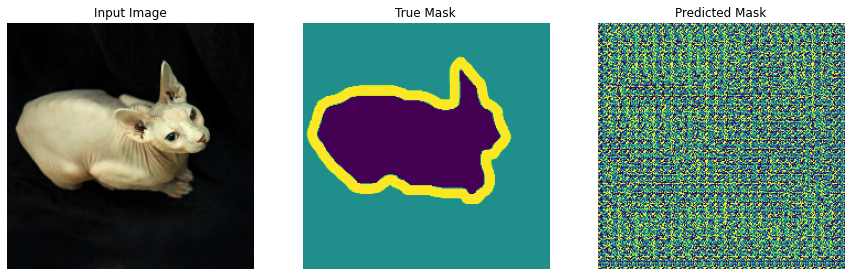

In [20]:
show_predictions()

#####Custom Callbacks & training Model

In [21]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    # clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

Epoch 1/50
57/57 [==============================] - 77s 963ms/step - loss: 1.1675 - accuracy: 0.3437 - val_loss: 0.8871 - val_accuracy: 0.5441


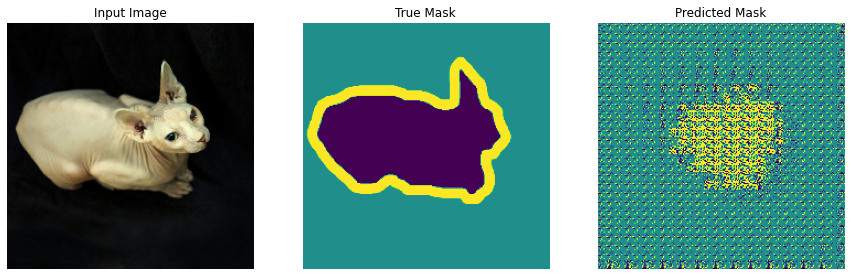


Sample Prediction after epoch 1

Epoch 2/50
57/57 [==============================] - 63s 936ms/step - loss: 0.7139 - accuracy: 0.6596 - val_loss: 0.5087 - val_accuracy: 0.7920


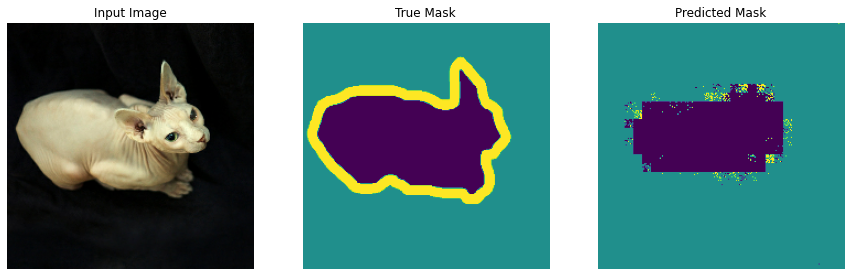


Sample Prediction after epoch 2

Epoch 3/50
57/57 [==============================] - 53s 934ms/step - loss: 0.4663 - accuracy: 0.8092 - val_loss: 0.4339 - val_accuracy: 0.8164


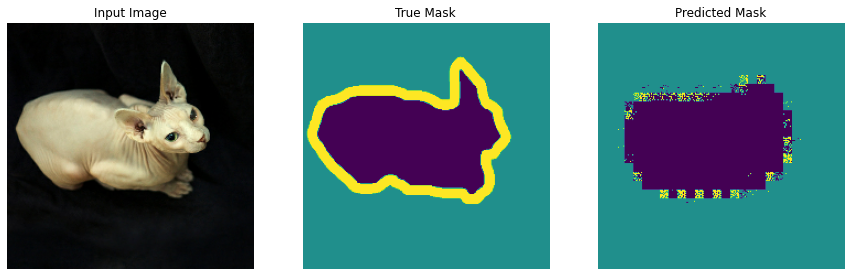


Sample Prediction after epoch 3

Epoch 4/50
57/57 [==============================] - 53s 934ms/step - loss: 0.4018 - accuracy: 0.8302 - val_loss: 0.4149 - val_accuracy: 0.8241


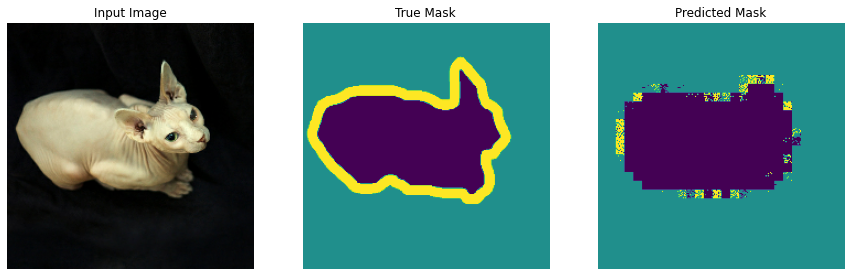


Sample Prediction after epoch 4

Epoch 5/50
57/57 [==============================] - 53s 934ms/step - loss: 0.3696 - accuracy: 0.8399 - val_loss: 0.4197 - val_accuracy: 0.8251


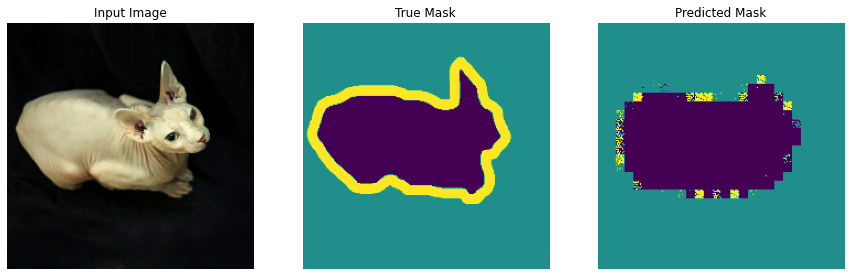


Sample Prediction after epoch 5

Epoch 6/50
57/57 [==============================] - 53s 935ms/step - loss: 0.3488 - accuracy: 0.8455 - val_loss: 0.3998 - val_accuracy: 0.8314


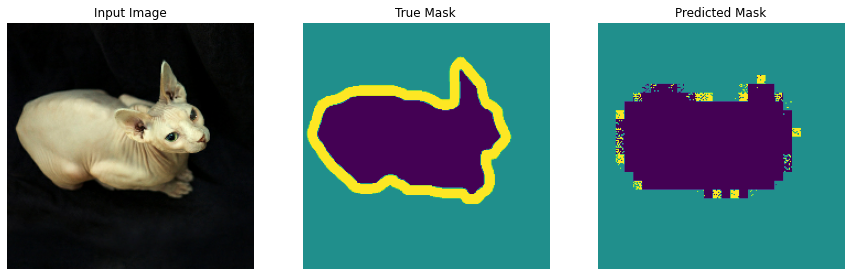


Sample Prediction after epoch 6

Epoch 7/50
57/57 [==============================] - 53s 936ms/step - loss: 0.3206 - accuracy: 0.8555 - val_loss: 0.4181 - val_accuracy: 0.8330


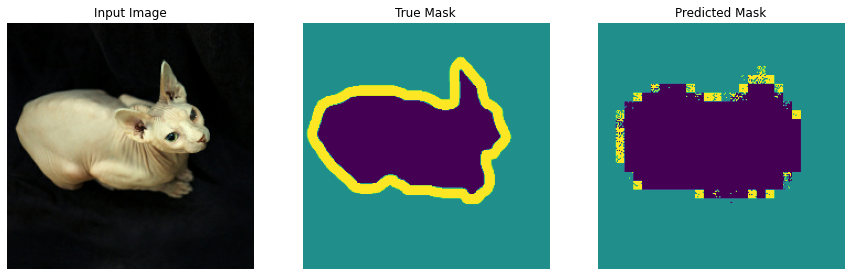


Sample Prediction after epoch 7

Epoch 8/50
57/57 [==============================] - 53s 937ms/step - loss: 0.3063 - accuracy: 0.8612 - val_loss: 0.4045 - val_accuracy: 0.8386


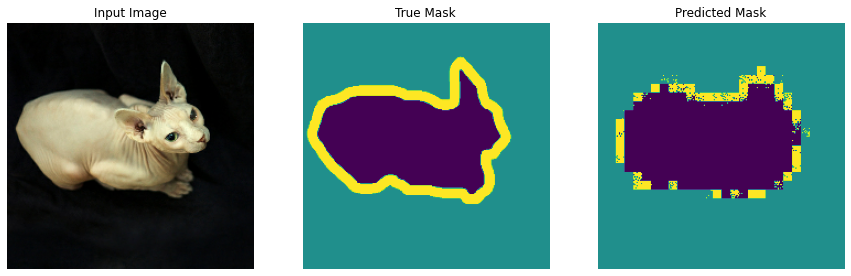


Sample Prediction after epoch 8

Epoch 9/50
57/57 [==============================] - 53s 936ms/step - loss: 0.2803 - accuracy: 0.8722 - val_loss: 0.4341 - val_accuracy: 0.8383


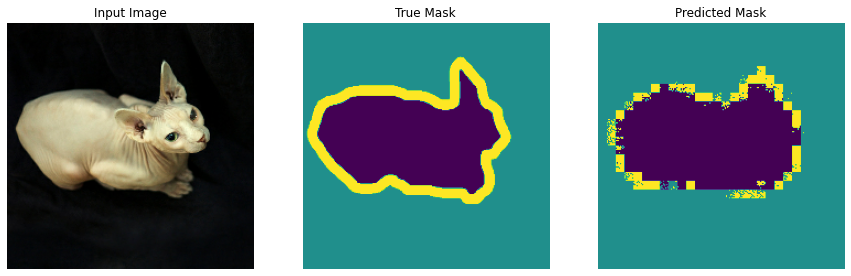


Sample Prediction after epoch 9

Epoch 10/50
57/57 [==============================] - 53s 938ms/step - loss: 0.2677 - accuracy: 0.8778 - val_loss: 0.4615 - val_accuracy: 0.8388


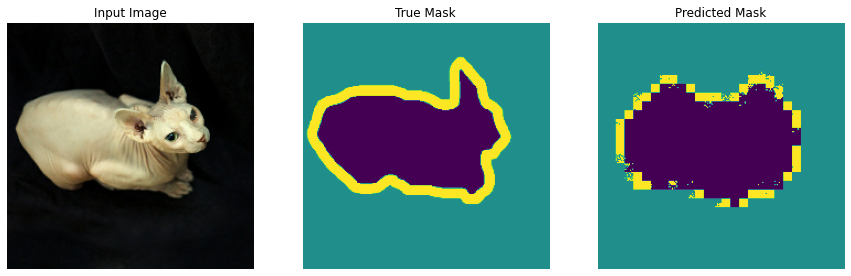


Sample Prediction after epoch 10

Epoch 11/50
57/57 [==============================] - 53s 935ms/step - loss: 0.2529 - accuracy: 0.8850 - val_loss: 0.4313 - val_accuracy: 0.8449


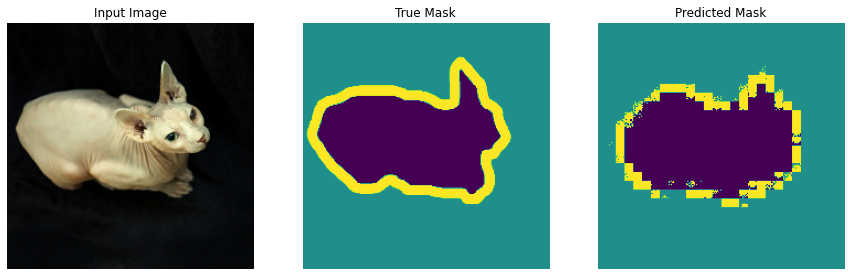


Sample Prediction after epoch 11

Epoch 12/50
57/57 [==============================] - 53s 935ms/step - loss: 0.2389 - accuracy: 0.8914 - val_loss: 0.4475 - val_accuracy: 0.8450


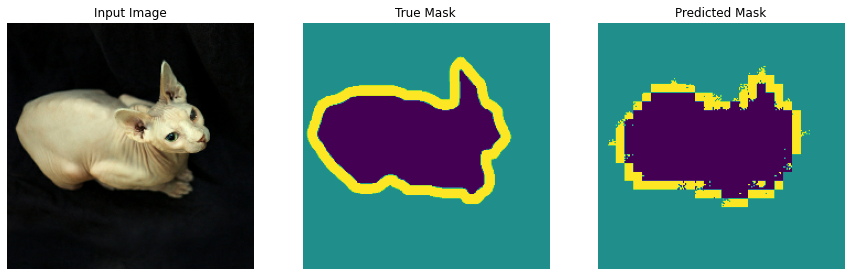


Sample Prediction after epoch 12

Epoch 13/50
57/57 [==============================] - 53s 937ms/step - loss: 0.2263 - accuracy: 0.8977 - val_loss: 0.4277 - val_accuracy: 0.8501


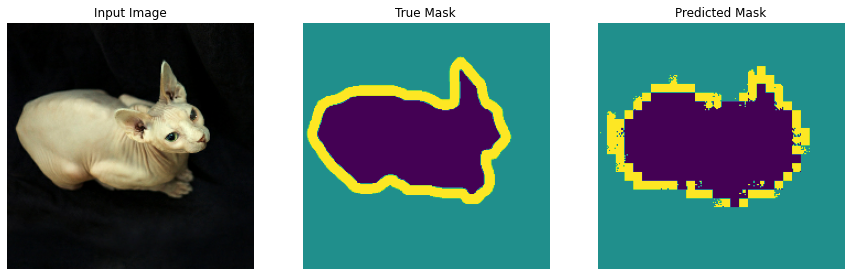


Sample Prediction after epoch 13

Epoch 14/50
57/57 [==============================] - 53s 937ms/step - loss: 0.2118 - accuracy: 0.9047 - val_loss: 0.4456 - val_accuracy: 0.8543


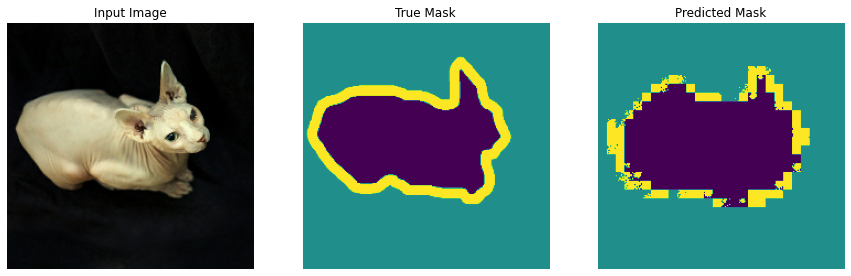


Sample Prediction after epoch 14

Epoch 15/50
57/57 [==============================] - 53s 936ms/step - loss: 0.2007 - accuracy: 0.9091 - val_loss: 0.4477 - val_accuracy: 0.8517


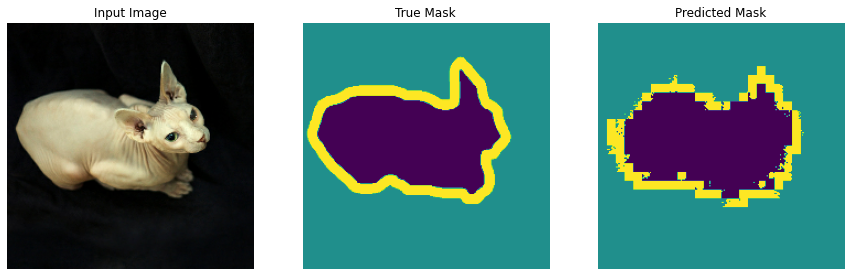


Sample Prediction after epoch 15

Epoch 16/50
57/57 [==============================] - 53s 937ms/step - loss: 0.1910 - accuracy: 0.9137 - val_loss: 0.4668 - val_accuracy: 0.8524


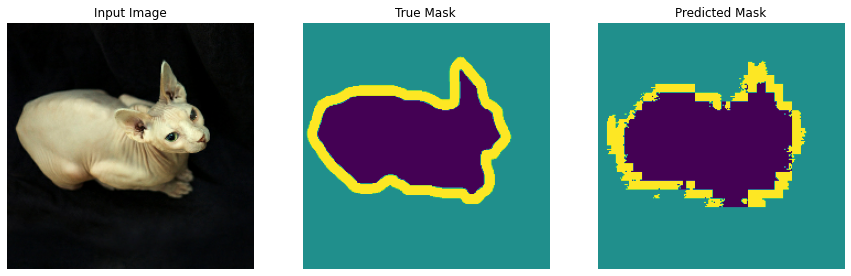


Sample Prediction after epoch 16

Epoch 17/50
57/57 [==============================] - 53s 934ms/step - loss: 0.1812 - accuracy: 0.9183 - val_loss: 0.4586 - val_accuracy: 0.8547


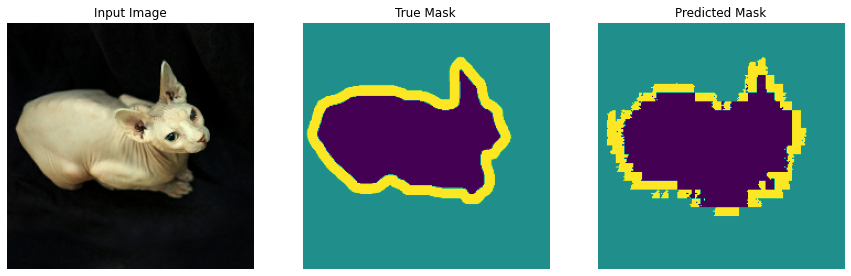


Sample Prediction after epoch 17

Epoch 18/50
57/57 [==============================] - 53s 937ms/step - loss: 0.1755 - accuracy: 0.9207 - val_loss: 0.4877 - val_accuracy: 0.8535


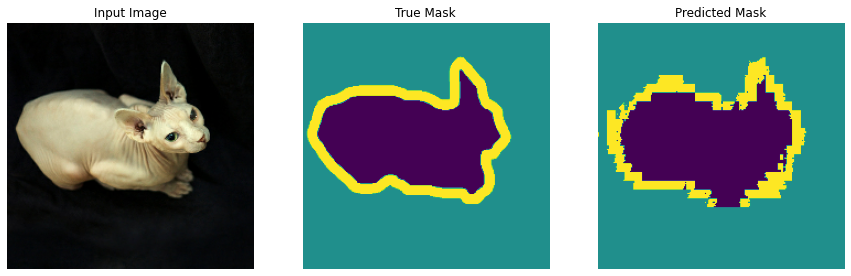


Sample Prediction after epoch 18

Epoch 19/50
57/57 [==============================] - 53s 936ms/step - loss: 0.1709 - accuracy: 0.9230 - val_loss: 0.5020 - val_accuracy: 0.8548


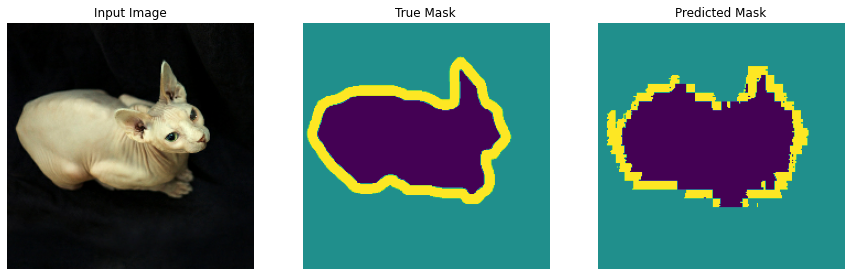


Sample Prediction after epoch 19

Epoch 20/50
57/57 [==============================] - 53s 938ms/step - loss: 0.1644 - accuracy: 0.9257 - val_loss: 0.5068 - val_accuracy: 0.8555


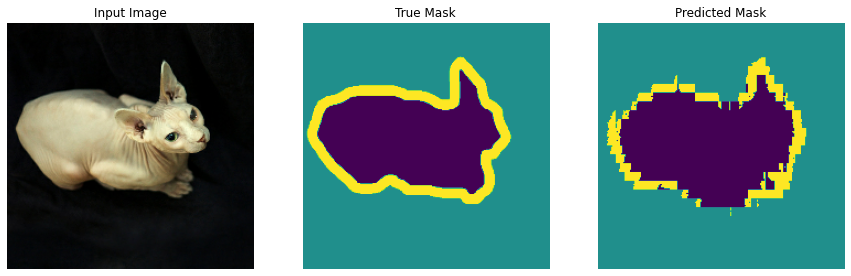


Sample Prediction after epoch 20

Epoch 21/50
57/57 [==============================] - ETA: 0s - loss: 0.1612 - accuracy: 0.9269

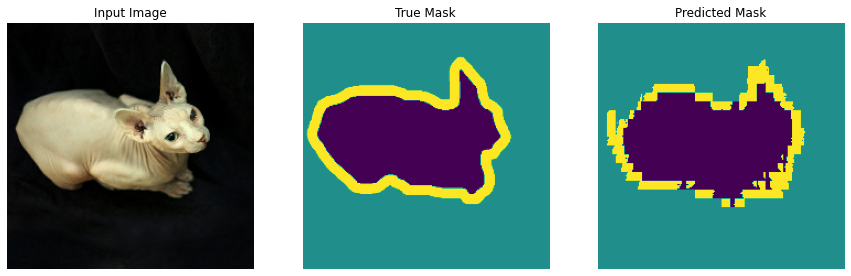


Sample Prediction after epoch 21

Epoch 22/50
57/57 [==============================] - 53s 934ms/step - loss: 0.1582 - accuracy: 0.9285 - val_loss: 0.5266 - val_accuracy: 0.8546


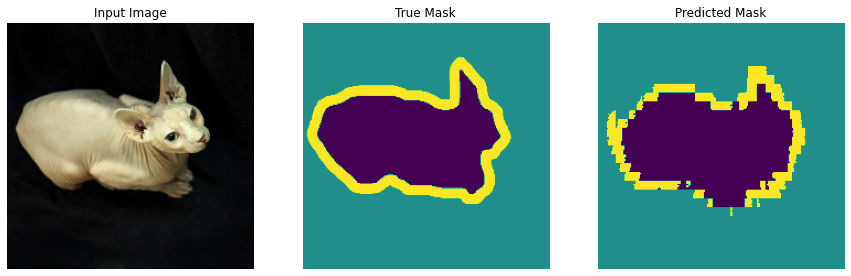


Sample Prediction after epoch 22

Epoch 23/50
57/57 [==============================] - 53s 935ms/step - loss: 0.1545 - accuracy: 0.9297 - val_loss: 0.5018 - val_accuracy: 0.8547


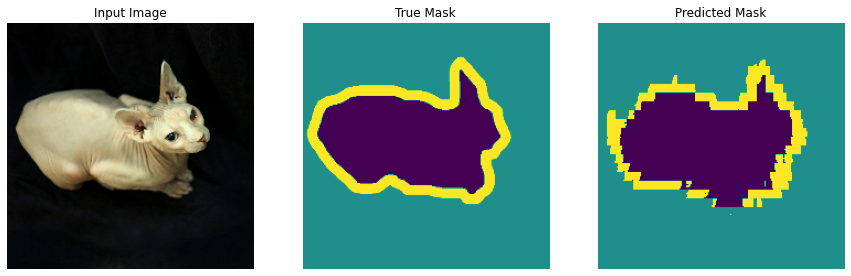


Sample Prediction after epoch 23

Epoch 24/50
57/57 [==============================] - 53s 936ms/step - loss: 0.1513 - accuracy: 0.9313 - val_loss: 0.5282 - val_accuracy: 0.8541


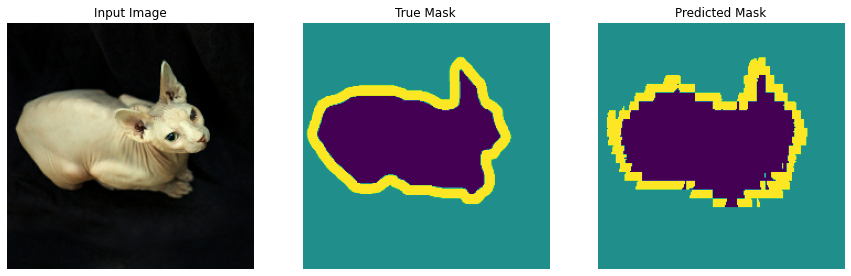


Sample Prediction after epoch 24

Epoch 25/50
57/57 [==============================] - 53s 938ms/step - loss: 0.1480 - accuracy: 0.9328 - val_loss: 0.5571 - val_accuracy: 0.8535


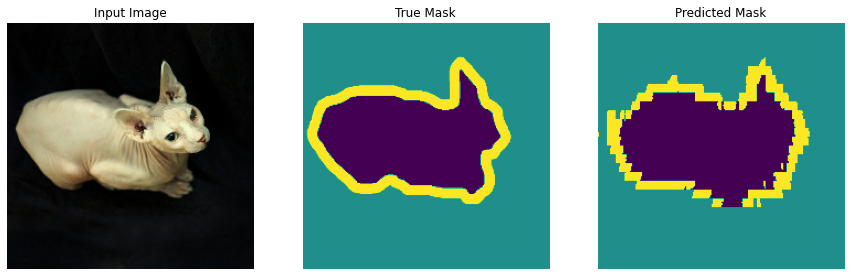


Sample Prediction after epoch 25

Epoch 26/50
57/57 [==============================] - 53s 936ms/step - loss: 0.1451 - accuracy: 0.9342 - val_loss: 0.5562 - val_accuracy: 0.8543


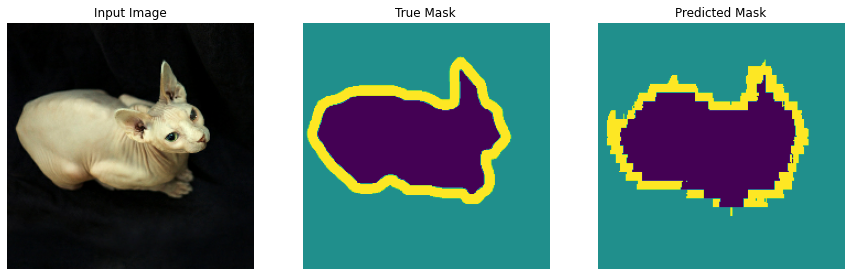


Sample Prediction after epoch 26

Epoch 27/50
57/57 [==============================] - 53s 936ms/step - loss: 0.1428 - accuracy: 0.9352 - val_loss: 0.5603 - val_accuracy: 0.8534


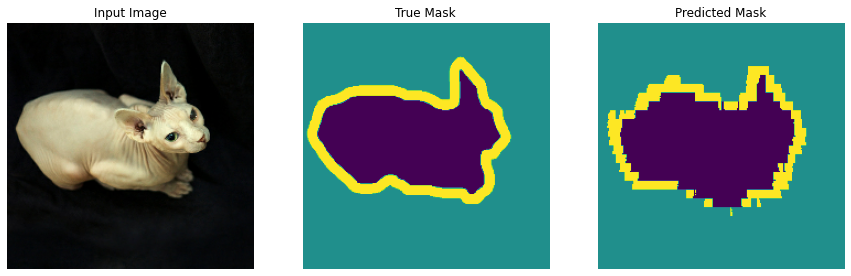


Sample Prediction after epoch 27

Epoch 28/50
57/57 [==============================] - 53s 934ms/step - loss: 0.1424 - accuracy: 0.9351 - val_loss: 0.5570 - val_accuracy: 0.8536


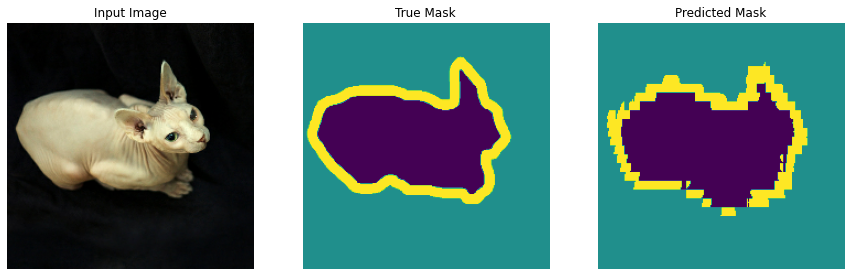


Sample Prediction after epoch 28

Epoch 29/50
57/57 [==============================] - 53s 936ms/step - loss: 0.1416 - accuracy: 0.9355 - val_loss: 0.5701 - val_accuracy: 0.8508


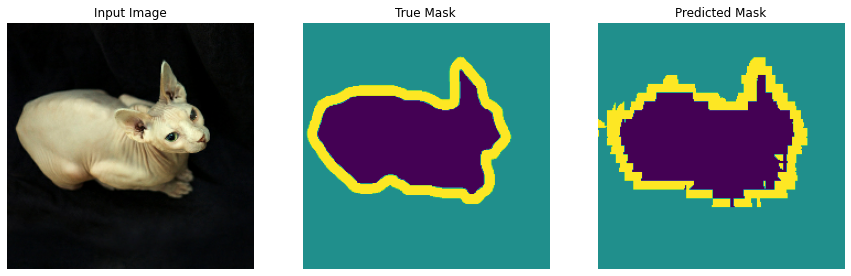


Sample Prediction after epoch 29

Epoch 30/50
57/57 [==============================] - 53s 937ms/step - loss: 0.1365 - accuracy: 0.9379 - val_loss: 0.5753 - val_accuracy: 0.8513


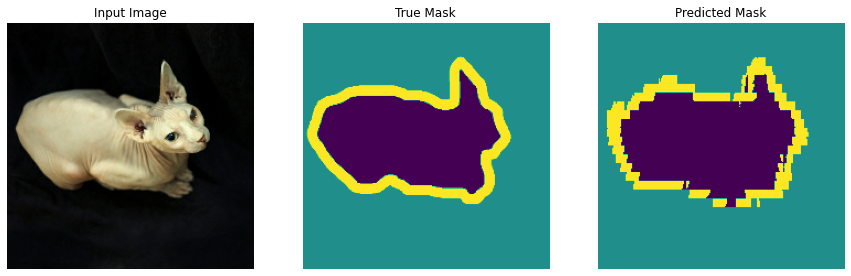


Sample Prediction after epoch 30

Epoch 31/50
57/57 [==============================] - 53s 936ms/step - loss: 0.1378 - accuracy: 0.9371 - val_loss: 0.6028 - val_accuracy: 0.8524


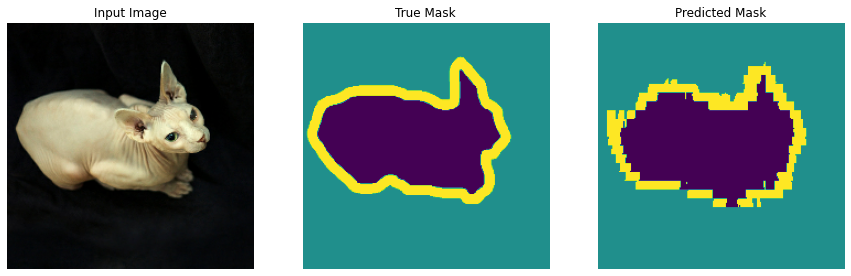


Sample Prediction after epoch 31

Epoch 32/50
57/57 [==============================] - 53s 935ms/step - loss: 0.1357 - accuracy: 0.9380 - val_loss: 0.5776 - val_accuracy: 0.8524


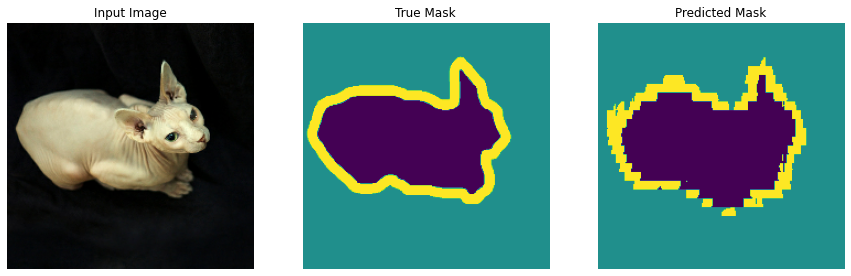


Sample Prediction after epoch 32

Epoch 33/50
57/57 [==============================] - 53s 935ms/step - loss: 0.1341 - accuracy: 0.9386 - val_loss: 0.5898 - val_accuracy: 0.8523


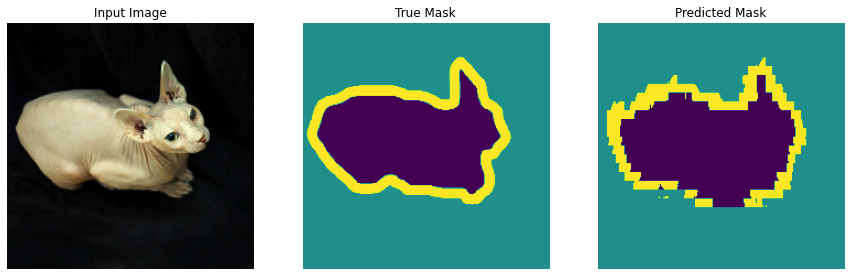


Sample Prediction after epoch 33

Epoch 34/50
57/57 [==============================] - 53s 937ms/step - loss: 0.1320 - accuracy: 0.9396 - val_loss: 0.5923 - val_accuracy: 0.8524


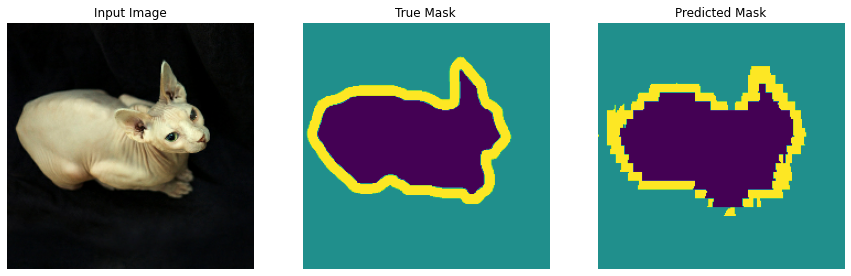


Sample Prediction after epoch 34

Epoch 35/50
57/57 [==============================] - 53s 935ms/step - loss: 0.1329 - accuracy: 0.9392 - val_loss: 0.5859 - val_accuracy: 0.8512


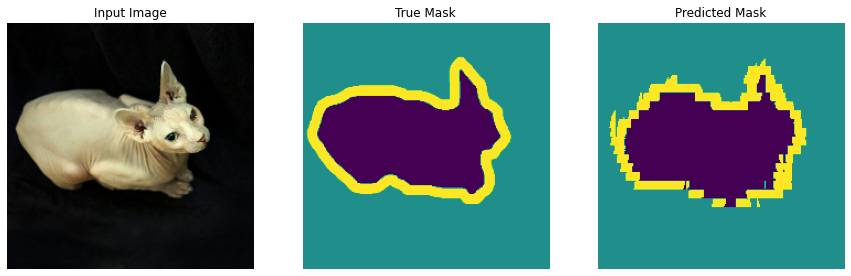


Sample Prediction after epoch 35

Epoch 36/50
57/57 [==============================] - 53s 935ms/step - loss: 0.1307 - accuracy: 0.9400 - val_loss: 0.6056 - val_accuracy: 0.8519


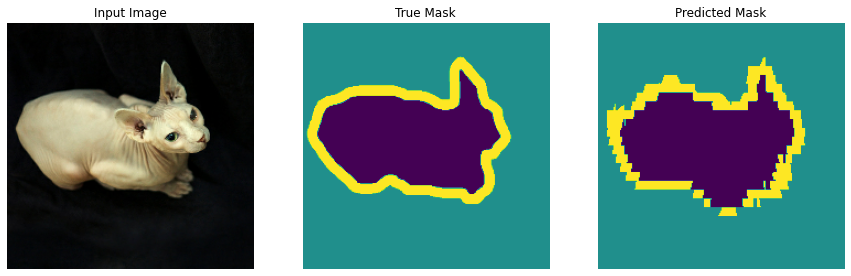


Sample Prediction after epoch 36

Epoch 37/50
57/57 [==============================] - 53s 936ms/step - loss: 0.1281 - accuracy: 0.9411 - val_loss: 0.6153 - val_accuracy: 0.8524


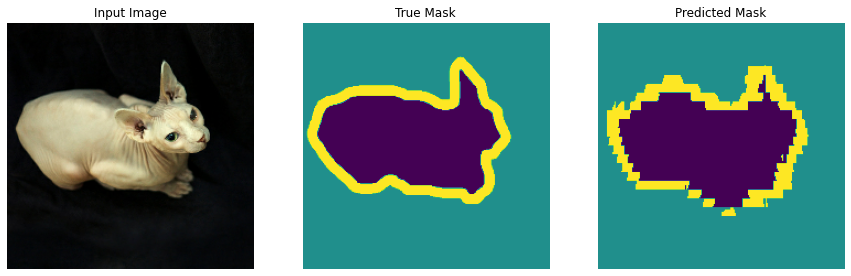


Sample Prediction after epoch 37

Epoch 38/50
57/57 [==============================] - 53s 935ms/step - loss: 0.1278 - accuracy: 0.9414 - val_loss: 0.6389 - val_accuracy: 0.8517


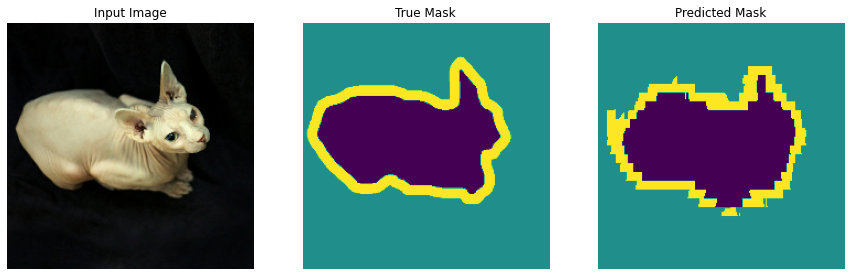


Sample Prediction after epoch 38

Epoch 39/50
57/57 [==============================] - 53s 936ms/step - loss: 0.1280 - accuracy: 0.9412 - val_loss: 0.6260 - val_accuracy: 0.8526


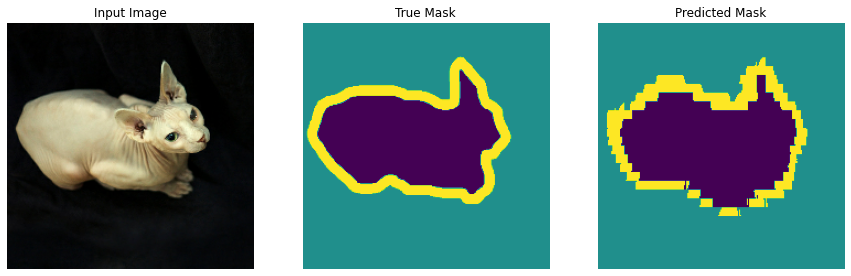


Sample Prediction after epoch 39

Epoch 40/50
57/57 [==============================] - 53s 936ms/step - loss: 0.1284 - accuracy: 0.9409 - val_loss: 0.6281 - val_accuracy: 0.8500


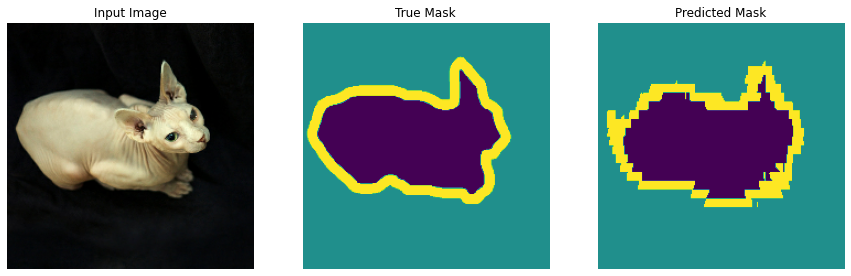


Sample Prediction after epoch 40

Epoch 41/50
57/57 [==============================] - 53s 933ms/step - loss: 0.1276 - accuracy: 0.9413 - val_loss: 0.6289 - val_accuracy: 0.8514


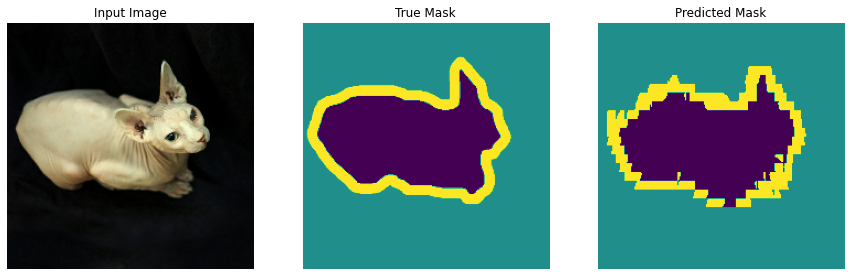


Sample Prediction after epoch 41

Epoch 42/50
57/57 [==============================] - 53s 936ms/step - loss: 0.1263 - accuracy: 0.9419 - val_loss: 0.6172 - val_accuracy: 0.8511


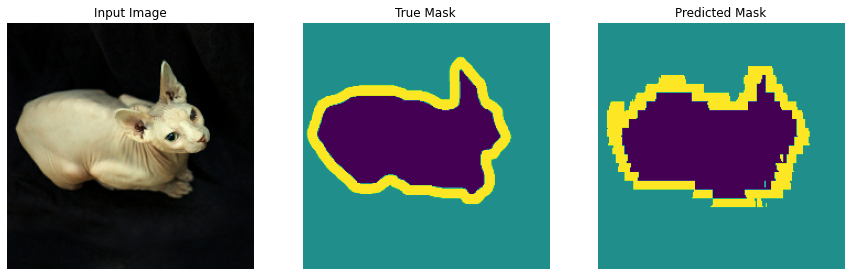


Sample Prediction after epoch 42

Epoch 43/50
57/57 [==============================] - 53s 939ms/step - loss: 0.1239 - accuracy: 0.9430 - val_loss: 0.6499 - val_accuracy: 0.8506


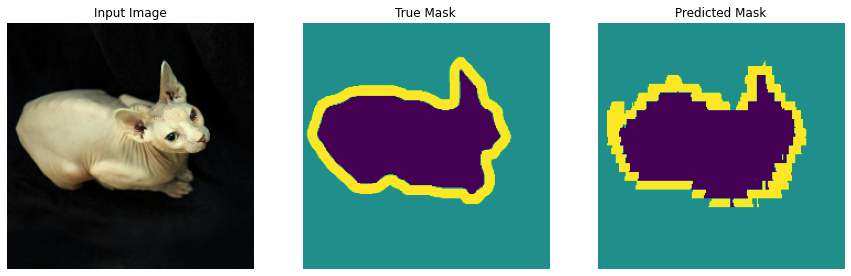


Sample Prediction after epoch 43

Epoch 44/50
57/57 [==============================] - 53s 936ms/step - loss: 0.1235 - accuracy: 0.9430 - val_loss: 0.6497 - val_accuracy: 0.8513


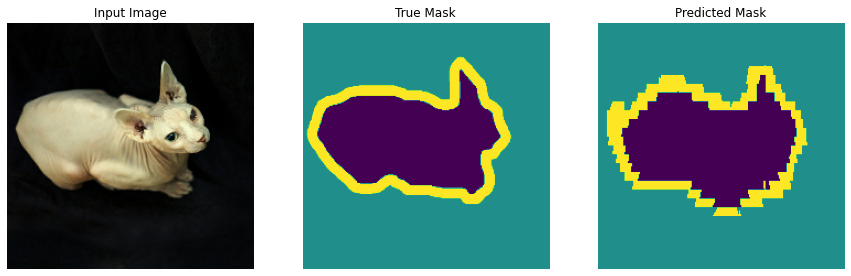


Sample Prediction after epoch 44

Epoch 45/50
57/57 [==============================] - 53s 935ms/step - loss: 0.1212 - accuracy: 0.9441 - val_loss: 0.6279 - val_accuracy: 0.8515


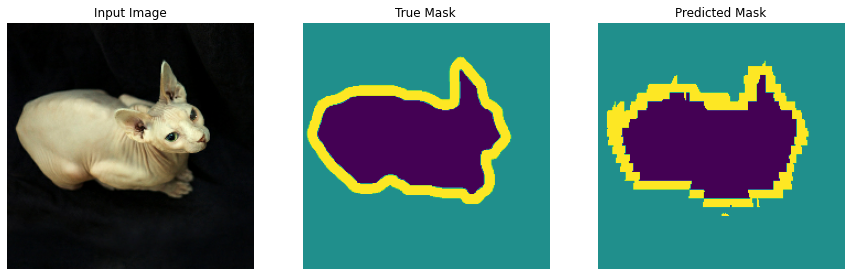


Sample Prediction after epoch 45

Epoch 46/50
57/57 [==============================] - 53s 937ms/step - loss: 0.1196 - accuracy: 0.9448 - val_loss: 0.6599 - val_accuracy: 0.8525


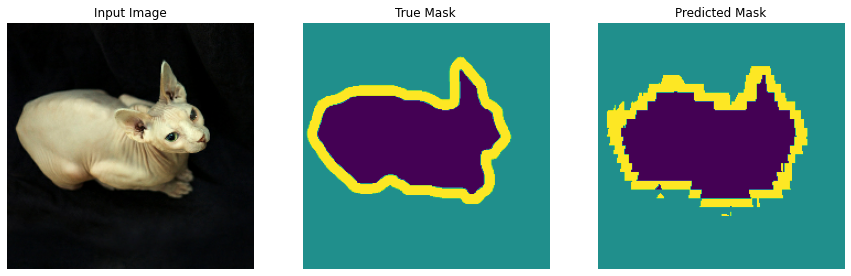


Sample Prediction after epoch 46

Epoch 47/50
57/57 [==============================] - 53s 936ms/step - loss: 0.1220 - accuracy: 0.9435 - val_loss: 0.6254 - val_accuracy: 0.8525


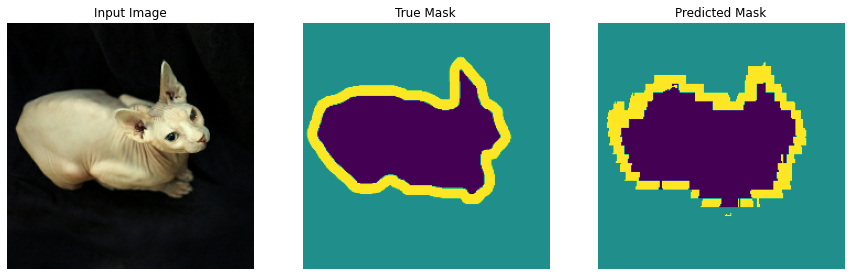


Sample Prediction after epoch 47

Epoch 48/50
57/57 [==============================] - 53s 935ms/step - loss: 0.1208 - accuracy: 0.9440 - val_loss: 0.6515 - val_accuracy: 0.8518


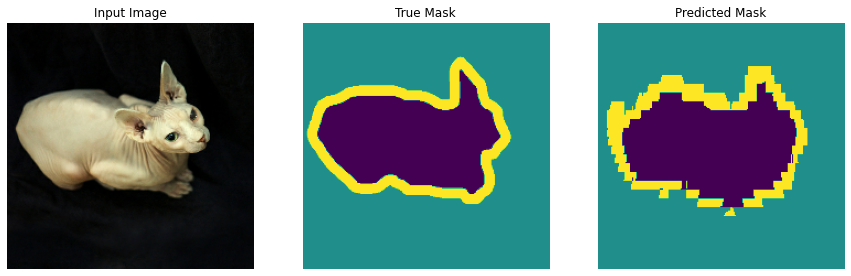


Sample Prediction after epoch 48

Epoch 49/50
57/57 [==============================] - 53s 935ms/step - loss: 0.1185 - accuracy: 0.9452 - val_loss: 0.6633 - val_accuracy: 0.8495


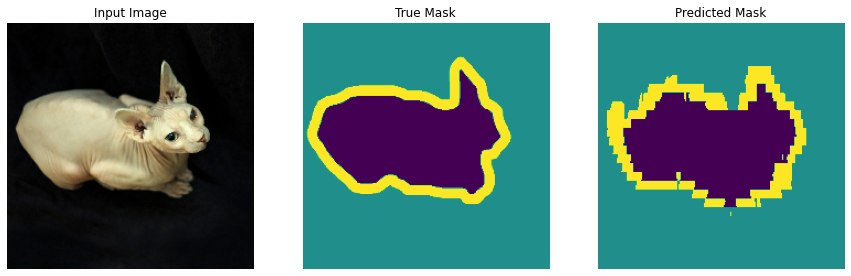


Sample Prediction after epoch 49

Epoch 50/50
57/57 [==============================] - 53s 936ms/step - loss: 0.1176 - accuracy: 0.9455 - val_loss: 0.6715 - val_accuracy: 0.8511


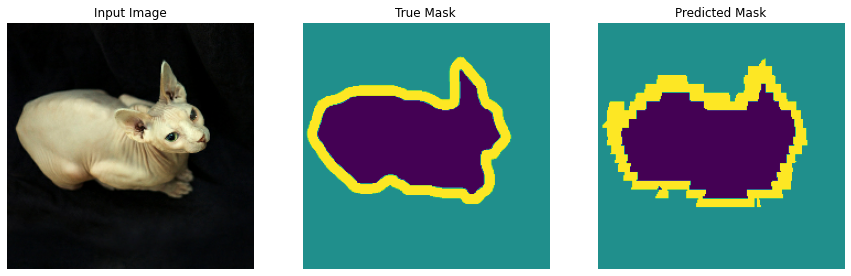


Sample Prediction after epoch 50



In [22]:
EPOCHS = 50
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_ds, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_ds,
                          callbacks=[DisplayCallback()])

#Compute Metrics
$$IOU = \frac{area\_of\_overlap}{area\_of\_union}$$

$$Dice Score = 2 * \frac{area\_of\_overlap}{combined\_area}$$

In [23]:

def compute_metrics(y_true, y_pred):
  '''
  Computes IOU and Dice Score.

  Args:
    y_true (tensor) - ground truth label map
    y_pred (tensor) - predicted label map
  '''
  
  class_wise_iou = []
  class_wise_dice_score = []

  smoothening_factor = 0.00001

  for i in range(3):
    intersection = np.sum((y_pred == i) * (y_true == i))
    y_true_area = np.sum((y_true == i))
    y_pred_area = np.sum((y_pred == i))
    combined_area = y_true_area + y_pred_area
    
    iou = (intersection + smoothening_factor) / (combined_area - intersection + smoothening_factor)
    class_wise_iou.append(iou)
    
    dice_score =  2 * ((intersection + smoothening_factor) / (combined_area + smoothening_factor))
    class_wise_dice_score.append(dice_score)

  return class_wise_iou, class_wise_dice_score

#Evaluate Model

In [24]:
def get_test_image_and_annotation_arrays():
  '''
  Unpacks the test dataset and returns the input images and segmentation masks
  '''

  ds = test_ds.unbatch()
  ds = ds.batch(info.splits['test'].num_examples)
  
  images = []
  y_true_segments = []

  for image, annotation in ds.take(1):
    y_true_segments = annotation.numpy()
    images = image.numpy()
  
  y_true_segments = y_true_segments[:(info.splits['test'].num_examples - (info.splits['test'].num_examples % BATCH_SIZE))]
  images = images[:(info.splits['test'].num_examples - (info.splits['test'].num_examples % BATCH_SIZE))]
  
  return images, y_true_segments

In [ ]:
y_true_images, y_true_segments = get_test_image_and_annotation_arrays()
results = model.predict(test_ds, steps=info.splits['test'].num_examples//BATCH_SIZE)
results = np.argmax(results, axis=3)
results = results[..., tf.newaxis]
results.shape

#####Display Class Wise Metrics

In [24]:
# compute the class wise metrics
cls_wise_iou, cls_wise_dice_score = compute_metrics(y_true_segments, results)
cls_wise_iou, cls_wise_dice_score

([0.18824124823064942, 0.24374094013231945, 0.09399310530892367],
 [0.31684011729262257, 0.3919480854371545, 0.17183491349772753])

In [25]:
# class list of the mask pixels
class_names = ['pet', 'background', 'outline']

# show the IOU for each class
for idx, iou in enumerate(cls_wise_iou):
  spaces = ' ' * (10-len(class_names[idx]) + 2)
  print("{}{}: {} ".format(class_names[idx], spaces, iou))

pet         : 0.18824124823064942 
background  : 0.24374094013231945 
outline     : 0.09399310530892367 


In [26]:
# show the Dice Score for each class
for idx, dice_score in enumerate(cls_wise_dice_score):
  spaces = ' ' * (10-len(class_names[idx]) + 2)
  print("{}{}: {} ".format(class_names[idx], spaces, dice_score))

pet         : 0.31684011729262257 
background  : 0.3919480854371545 
outline     : 0.17183491349772753 


In [27]:
y_true_images.shape

(3648, 224, 224, 3)

#Show Predictions and Metrics

In [28]:
integer_slider = 2574
img = np.reshape(y_true_images[integer_slider], (1, width, height, 3))
y_pred_mask = model.predict(img)
y_pred_mask = create_mask(y_pred_mask)
y_pred_mask.shape

TensorShape([224, 224, 1])

In [33]:
def display_prediction(display_list, display_string):
  plt.figure(figsize = (15, 15))
  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.xticks([])
    plt.yticks([])
    if i == 1:
      plt.xlabel(display_string, fontsize = 12)
    plt.imshow(keras.preprocessing.image.array_to_img(display_list[i]))
    # plt.axis('off')
  # plt.xlabel(display_string, fontsize = 14)
  plt.show()

In [ ]:
iou, dice_score = compute_metrics(y_true_segments[integer_slider], y_pred_mask.numpy())
display_list = [y_true_images[integer_slider], y_true_segments[integer_slider], y_pred_mask]

display_string_list = ["{}: IOU: {} Dice Score: {}".format(class_names[idx], i, dc) for idx, (i, dc) in 
                       enumerate(zip(np.round(iou, 4), np.round(dice_score, 4)))]
display_string = "\n\n".join(display_string_list)


# showing predictions with metrics
display_prediction(display_list, display_string)